c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


KeyboardInterrupt: 

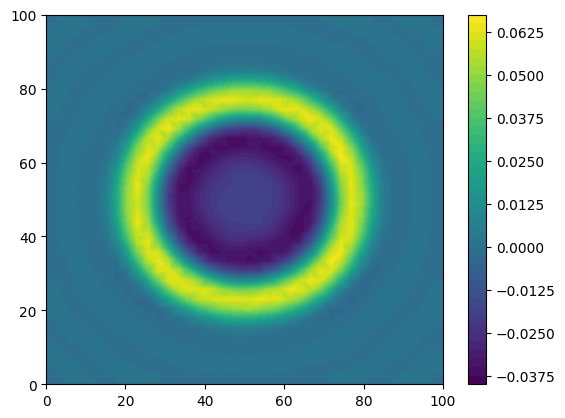

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
from PIL import Image

#definir condiciones inixiales
def initial_conditions(vertices):
    U = 10 * np.exp(-np.sqrt((vertices[:,0]-50)**2 + (vertices[:,1]-50)**2))

    V = np.zeros_like(U)
    return U, V
# crear la malla de elementos triangulares
def generate_mesh(N):
    x = np.linspace(0, 100, N)
    y = np.linspace(0, 100, N)
    xv, yv = np.meshgrid(x, y)
    vertices = np.vstack((xv.flatten(), yv.flatten())).T
    return vertices, Delaunay(vertices)
# aplicar las condiciones de frontera de Dirichlet a la matriz de rigidez y masa
def apply_dirichlet_bc(K, M, vertices):
    n_nodes = len(vertices)
    for node in range(n_nodes):
        if np.isclose(vertices[node][0], 0) or np.isclose(vertices[node][0], 100) or \
           np.isclose(vertices[node][1], 0) or np.isclose(vertices[node][1], 100):
            K[node,:] = 0
            K[:,node] = 0
            K[node,node] = 1
            M[node,:] = 0
            M[:,node] = 0
            M[node,node] = 1
    return K, M
#montaje del sistema 
def assemble_system(elements, vertices):
    n_nodes = len(vertices)
    K = np.zeros((n_nodes, n_nodes))
    M = np.zeros((n_nodes, n_nodes))
    for element in elements:
        i, j, k = element
        xi, xj, xk = vertices[i][0], vertices[j][0], vertices[k][0]
        yi, yj, yk = vertices[i][1], vertices[j][1], vertices[k][1]
        A = 0.5*abs((xj*yk + xi*yj + xk*yi) - (xk*yj + xj*yi + xi*yk))
        ci = yj - yk
        cj = yk - yi
        ck = yi - yj
        di = xk - xj
        dj = xi - xk
        dk = xj - xi
        K_local = np.array([[ci*ci + di*di, ci*cj + di*dj, ci*ck + di*dk],
                            [cj*ci + dj*di, cj*cj + dj*dj, cj*ck + dj*dk],
                            [ck*ci + dk*di, ck*cj + dk*dj, ck*ck + dk*dk]])/(4*A)
        M_local = np.array([[2, 1, 1],
                            [1, 2, 1],
                            [1, 1, 2]])*(A/12)
        for m, row_m in zip(element, M_local):
            for n, value in zip(element, row_m):
                M[m,n] += value
        for m, row_m in zip(element, K_local):
            for n, value in zip(element, row_m):
                K[m,n] += value
    return K, M
#main y uso de las funciones planteadas anteriormente
def main():
    N = 40
    C = 1
    dt = 0.1
    n_steps = 300

    vertices, tri = generate_mesh(N)
    elements = tri.simplices

    K, M = assemble_system(elements, vertices)
    K, M = apply_dirichlet_bc(K, M, vertices)
# se itera y se guardan los resultados de las matrices 
    U, V = initial_conditions(vertices)
    U_old = U.copy()
    U_new = U.copy()

    frames = []
# usa esquema de difrencias finitas 
    for step in range(n_steps):
        if step > 0:
            U_old = U.copy()
            U = U_new.copy()

        A = M + 0.5 * (C*2) * (dt*2) * K
        B = M - 0.5 * (C*2) * (dt*2) * K
        rhs = B.dot(2*U - U_old)
#se soluciona el sistema (ecuación de onda en el tiempo)
        U_new = spsolve(A, rhs)
# se grafica 
        if step % 1 == 0:
            plt.figure()
            plt.tricontourf(vertices[:, 0], vertices[:, 1], U_new, 50)
            plt.colorbar()
            plt.title('Step %d' % step)
            plt.gca().set_aspect('equal', 'box')
 # Guardar cada frame en cada instante de tiempo
            plt.savefig('frame%d.png' % step)
            plt.close()

            # Añadir a lista de frames
            frames.append(Image.open('frame%d.png' % step))

    # Guardar gif
    frames[0].save('animation2d.gif', save_all=True, append_images=frames[1:], optimize=False, duration=150, loop=0)

    for frame_file in frames:
        frame_file.close()

    print("Animation saved as animation2d.gif")



main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
from PIL import Image

# Define condiciones iniciales
def initial_conditions(vertices):
    U = 10 * np.exp(-4 * np.sqrt((vertices[:,0]-50)**2 + (vertices[:,1]-50)**2))
    V = np.zeros_like(U)
    return U, V

# Genera malla de elementos triangulares
def generate_mesh(N):
    x = np.linspace(0, 100, N)
    y = np.linspace(0, 100, N)
    xv, yv = np.meshgrid(x, y)
    vertices = np.vstack((xv.flatten(), yv.flatten())).T
    return vertices, Delaunay(vertices)

# Aplica condiciones de Dirichlet
def apply_dirichlet_bc(K, M, vertices):
    n_nodes = len(vertices)
    for node in range(n_nodes):
        if np.isclose(vertices[node][0], 0) or np.isclose(vertices[node][0], 100) or \
           np.isclose(vertices[node][1], 0) or np.isclose(vertices[node][1], 100):
            K[node,:] = 0
            K[:,node] = 0
            K[node,node] = 1
            M[node,:] = 0
            M[:,node] = 0
            M[node,node] = 1
    return K, M

# Se ensamblan las matrices de masa y rigidez
def assemble_system(elements, vertices):
    n_nodes = len(vertices)
    K = np.zeros((n_nodes, n_nodes))
    M = np.zeros((n_nodes, n_nodes))
    for element in elements:
        i, j, k = element
        xi, xj, xk = vertices[i][0], vertices[j][0], vertices[k][0]
        yi, yj, yk = vertices[i][1], vertices[j][1], vertices[k][1]
        A = 0.5*abs((xj*yk + xi*yj + xk*yi) - (xk*yj + xj*yi + xi*yk))
        ci = yj - yk
        cj = yk - yi
        ck = yi - yj
        di = xk - xj
        dj = xi - xk
        dk = xj - xi
        K_local = np.array([[ci*ci + di*di, ci*cj + di*dj, ci*ck + di*dk],
                            [cj*ci + dj*di, cj*cj + dj*dj, cj*ck + dj*dk],
                            [ck*ci + dk*di, ck*cj + dk*dj, ck*ck + dk*dk]])/(4*A)
        M_local = np.array([[2, 1, 1],
                            [1, 2, 1],
                            [1, 1, 2]])*(A/12)
        for m, row_m in zip(element, M_local):
            for n, value in zip(element, row_m):
                M[m,n] += value
        for m, row_m in zip(element, K_local):
            for n, value in zip(element, row_m):
                K[m,n] += value
    return K, M

# Se plantea el main y parámetros
def main():
    N = 40
    C = 1
    dt = 0.1
    n_steps = 200

    vertices, tri = generate_mesh(N)
    elements = tri.simplices

    K, M = assemble_system(elements, vertices)
    K, M = apply_dirichlet_bc(K, M, vertices)

# se definen condiciones iniciales

    U, V = initial_conditions(vertices)
    U_old = U.copy()
    U_new = U.copy()

    frames = []

    for step in range(n_steps):
        if step > 0:
            U_old = U.copy()
            U = U_new.copy()

        A = M + 0.5 * (C*2) * (dt*2) * K
        B = M - 0.5 * (C*2) * (dt*2) * K
        rhs = B.dot(2*U - U_old)
        U_new = spsolve(A, rhs)

# se comienzan iteraciones y se establece el paso 
        if step % 1 == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], U_new, cmap='viridis')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title('Step %d' % step)
            mappable = ax.collections[0]
            fig.colorbar(mappable, ax=ax)

            # Guardar cada frame
            plt.savefig('frame%d.png' % step)
            plt.close()

            # Añadir cada frame a lista de frames
            frames.append(Image.open('frame%d.png' % step))

    # Guardar como gif
    frames[0].save('animation3d.gif', save_all=True, append_images=frames[1:], optimize=False, duration=180, loop=0)

    
    for frame_file in frames:
        frame_file.close()

    print("Animation saved as animation3d.gif")

main()